In [1]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.optim import AdamW


In [2]:
df_unlabeled = pd.read_pickle("../data/data_clean.pkl")
df_unlabeled = df_unlabeled[["contract","paragraph","section","section_content","clean_section_content"]]
display(df_unlabeled)


mapping = pd.read_excel("../data/mapping_human.xlsx")
mapping = mapping[["section_content","catalog_id"]]
display(mapping)

df_labeled = mapping.merge(df_unlabeled, how = "left", on = "section_content")
df_labeled= df_labeled[["contract","paragraph","section","clean_section_content","catalog_id"]]

catalogue = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue = catalogue.rename(columns={'example': 'clean_section_content'})
catalogue = catalogue[['clean_section_content']]
catalogue["catalog_id"] = range(len(catalogue))


df_labeled=pd.concat([catalogue, df_labeled], ignore_index=True)[["clean_section_content","catalog_id"]]
display(df_labeled)
df_labeled.to_excel("../data/train_data.xlsx")


,contract,paragraph,section,section_content,clean_section_content
0,1,§ 1,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...,der anbieter stellt dem kunden die software de...
1,1,§ 1,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...,die nutzung umfasst die bereitstellung von fun...
2,1,§ 1,1.3,1.3 Der Kunde erhält ausschließlich das vertra...,der kunde erhält ausschließlich das vertraglic...
3,2,§ 1,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...,dieser software service vertrag ist auf line b...
4,2,§ 1,(2),(2) Die Software wird vom Anbieter als webbasi...,die software wird vom anbieter als webbasierte...
...,...,...,...,...,...
1371,26,19.,19.2,"19.2 Anhänge sind in ihrer jeweils gültigen, d...",anhänge sind ihrer jeweils gültigen von beiden...
1372,26,19.,19.3,19.3 Nebenbestimmungen außerhalb dieses Vertra...,nebenbestimmungen außerhalb dieses vertrags un...
1373,26,19.,19.4,19.4 Die etwaige Unwirksamkeit einzelner Besti...,die etwaige unwirksamkeit einzelner bestimmung...
1374,26,19.,19.5,19.5 Ergeben sich in der praktischen Infrastru...,ergeben sich der praktischen infrastruktur die...


,section_content,catalog_id
0,(1) Zahlungszeitraum und Höhe der Vergütung ri...,1
1,(2) Die außerordentliche Kündigung aus wichtig...,69
2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,31
3,5.2. Alle Vergütungen unterliegen den jeweils ...,8
4,6.3. Im Falle einer Kündigung des Auftraggeber...,70
...,...,...
59,16.1 Das Vertragsverhältnis beginnt mit dem Zu...,68
60,17.1 Vorzeitige Beendigung des Vertrages wegen...,57
61,17.3 Pflichten von 4SELLERS 4SELLERS unterstüt...,58
62,17.6 Datenlöschung nach Vollzug des Wechsels 4...,59


,clean_section_content,catalog_id
0,im festpreis von sind sämtliche leistungen ein...,0
1,der kunde zahlt eine monatliche pauschale von ...,1
2,die vergütung ist drei raten zahlbar bei proje...,2
3,alle preise verstehen sich euro zuzüglich gese...,3
4,reise und übernachtungskosten werden nur ersta...,4
...,...,...
146,das vertragsverhältnis beginnt mit dem zugang ...,68
147,vorzeitige beendigung des vertrages wegen wech...,57
148,pflichten von sellers sellers unterstützt den ...,58
149,datenlöschung nach vollzug des wechsels seller...,59


In [3]:
df_labeled.catalog_id.value_counts()

catalog_id
44    3
26    3
21    3
22    3
67    3
     ..
17    1
11    1
10    1
7     1
76    1
Name: count, Length: 77, dtype: int64

In [4]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
tokenizer = tokenizer.backend_tokenizer

In [5]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn

class MultilingualParaphraseClassifier(nn.Module):
    
    def __init__(self, model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', num_labels=77):
        super(MultilingualParaphraseClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Output der letzten Hidden States
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Mean Pooling über Token-Dimension
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        mean_pooled = torch.sum(last_hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        
        # Klassifikation
        out = self.dropout(mean_pooled)
        logits = self.classifier(out)
        return logits


In [6]:
model = MultilingualParaphraseClassifier()
model

MultilingualParaphraseClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e

In [7]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_labeled['clean_section_content'].tolist(),
    df_labeled['catalog_id'].tolist(),
    test_size=0.2,
    random_state=42
)

valid_texts, test_texts, valid_labels, test_labels = train_test_split(
    test_texts,
    test_labels,
    test_size=0.5,
    random_state=42
)

In [8]:
print(len(train_texts))
print(len(test_texts))
print(len(valid_texts))

120
16
15


In [9]:
from transformers import AutoTokenizer

# Lade den richtigen, aufrufbaren Tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Jetzt kannst du Texte korrekt tokenisieren
train_encodings = tokenizer(
    train_texts, truncation=True, padding=True,  return_tensors='pt')
test_encodings = tokenizer(
    test_texts, truncation=True, padding=True,  return_tensors='pt')
test_encodings = tokenizer(
    test_texts, truncation=True, padding=True, return_tensors='pt')


In [10]:
low_level = tokenizer.backend_tokenizer
encodings = low_level.encode_batch(train_texts)

# Zugriff auf Rohdaten
for encoding in encodings[:1]:
    print(encoding.tokens)         # Tokenliste
    print(encoding.ids)            # Token IDs
    print(encoding.attention_mask) # Attention Mask

['<s>', '▁der', '▁projekt', 'zeit', 'plan', '▁wird', '▁als', '▁', 'anlage', '▁fest', 'geschrieben', '▁wichtige', '▁meil', 'enstein', 'e', '▁sind', '▁ab', 'schluss', '▁der', '▁', 'konzept', 'phase', '▁bis', '▁fertig', 'stellung', '▁der', '▁implement', 'ierung', '▁bis', '▁begin', 'n', '▁integration', 'stest', '▁live', '▁zum', '▁konkrete', '▁meil', 'enstein', 'zi', 'ele', '▁und', '▁termine', '▁sind', '▁dem', '▁plan', '▁', 'anlage', '▁zu', '▁en', 't', 'nehmen', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [11]:
train_texts[0:5]

['der projektzeitplan wird als anlage festgeschrieben wichtige meilensteine sind abschluss der konzeptphase bis fertigstellung der implementierung bis beginn integrationstest live zum konkrete meilensteinziele und termine sind dem plan anlage zu entnehmen',
 'ist das projekt bzw sind die einzelnen stufen mehr als sechs wochen im echtbetrieb gilt das projekt bzw teilprojekt als abgenommen',
 'nicht bestandteil dieses vertrags sind die lieferung von hardware die bereitstellung von datenbanklizenzen sowie anpassungen legacy crm des kunden diese leistungen liegen der verantwortung des kunden bzw werden gesondert beauftragt',
 'die ziff aufgeführten leistungen werden durch die im produktschein oder individualvertrag vereinbarte pauschalierte wartungsgebühr abgegolten die fahrtkosten und fahrtzeiten sowie übernachtungskosten und tagesspesen werden gesondert rechnung gestellt csb behält sich das recht vor im wartungsfalle bei nicht aktueller programmversion dem kunden die aktuelle programmver

In [12]:
train_encodings[0:5]

[Encoding(num_tokens=475, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=475, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=475, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=475, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=475, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]

In [13]:
#labels to tensors
train_labels_t =torch.tensor(train_labels)
test_labels_t = torch.tensor(test_labels)
valid_labels_t = torch.tensor(test_labels)

In [14]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_t) #attention masks to consider the padding and avoid paying attention to padding tokens
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_t)
valid_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], valid_labels_t)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [15]:
epochs = 50  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
optim = AdamW(model.parameters(), lr=5e-5) #

In [16]:

# accumulate the losses, can be used with a validation set to choose the epochs so as to avoid overfitting
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
  model.train() # switch to train mode i.e. forward, backward, optimization
  train_total_loss = 0
  for batch in train_loader: # split into batches to fit into the memory
        input_ids, attention_mask, labels = batch

        # Always cler any previously calculated gradients before performing a
        # backward pass. Otherwise you have incorrect values from teh previous batch.
        optim.zero_grad()


        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/docs/transformers/model_doc/bert
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        #print(loss)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python number
        # from the tensor.
        train_total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Update parameters using the optimizer and the gradient values
        optim.step()
  avg_train_loss = train_total_loss / len(train_loader)
  train_losses.append(avg_train_loss)  # Store training loss
  print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

  # Validation Loop
  model.eval()
  val_loss = 0
  all_val_preds = []
  all_val_labels = []

  with torch.no_grad():
      for batch in valid_loader:
          input_ids, attention_mask, labels = batch
          

          logits = model(input_ids=input_ids, attention_mask=attention_mask)
          loss = criterion(logits, labels)    
          val_loss += loss.item()

          probs = torch.softmax(logits, dim=1)
          max_probs, preds = torch.max(probs, dim=1)
          #threshold = 0.4985
          #preds[max_probs < threshold] = -99  # Unsichere Vorhersagen

  avg_val_loss = val_loss / len(valid_loader)
  val_losses.append(avg_val_loss)  # Store validation loss
  print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

  # Early Stopping Check
  if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
      torch.save(model.state_dict(), "best_model.pth")  # Save the best model
      print("Model saved!")
  else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered. Training stopped.")
          break  # Stop training if no improvement

# Load the best model before evaluation
model.load_state_dict(torch.load("best_model.pth"))

Epoch 1, Training Loss: 4.3519
Epoch 1, Validation Loss: 4.3674
Model saved!
Epoch 2, Training Loss: 4.2356
Epoch 2, Validation Loss: 4.3932
Epoch 3, Training Loss: 4.1083
Epoch 3, Validation Loss: 4.4204
Epoch 4, Training Loss: 3.9518
Epoch 4, Validation Loss: 4.4041
Epoch 5, Training Loss: 3.7395
Epoch 5, Validation Loss: 4.3711
Epoch 6, Training Loss: 3.5608
Epoch 6, Validation Loss: 4.3572
Model saved!
Epoch 7, Training Loss: 3.3763
Epoch 7, Validation Loss: 4.3388
Model saved!
Epoch 8, Training Loss: 3.1494
Epoch 8, Validation Loss: 4.3977
Epoch 9, Training Loss: 2.9680
Epoch 9, Validation Loss: 4.3661
Epoch 10, Training Loss: 2.8664
Epoch 10, Validation Loss: 4.3659
Epoch 11, Training Loss: 2.7044
Epoch 11, Validation Loss: 4.3637
Epoch 12, Training Loss: 2.5180
Epoch 12, Validation Loss: 4.3673
Early stopping triggered. Training stopped.


<All keys matched successfully>

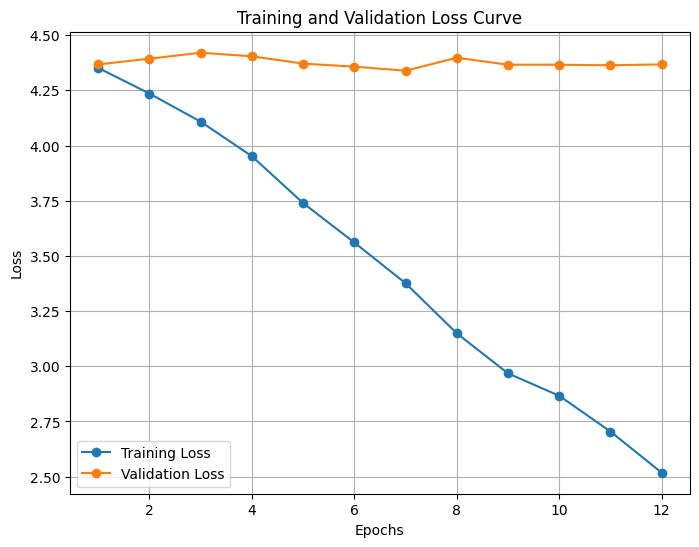

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [18]:
from sklearn.metrics import classification_report, accuracy_score
# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()
all_preds = []
all_labels = []
# Telling the model not to compute or store gradients, saving memory and
# speeding up the process
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch


        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        probs = torch.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)
        #threshold = 0.4985
        #preds[max_probs < threshold] = -99
        print(f"Batch size: {len(labels)}, Predictions: {len(preds)}")

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation
print(f"Length of all_labels: {all_labels}")
print(f"Length of all_preds: {all_preds}")
import numpy as np
# 🔎 Optional: Zeige wie oft -99 vorkam
print(f"Anzahl -99 Vorhersagen: {(np.array(all_preds) == -99).sum()}")

# 📊 Report mit expliziten Klassen
print("Test Set Evaluation:")
print(classification_report(all_labels, all_preds))

Batch size: 16, Predictions: 16
Length of all_labels: [67, 23, 5, 68, 55, 39, 30, 26, 36, 1, 63, 43, 31, 9, 12, 26]
Length of all_preds: [59, 24, 47, 35, 44, 35, 15, 21, 59, 15, 62, 9, 30, 53, 34, 24]
Anzahl -99 Vorhersagen: 0
Test Set Evaluation:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       0.0
          21       0.00      0.00      0.00       0.0
          23       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       0.0
          26       0.00      0.00      0.00       2.0
          30       0.00      0.00      0.00       1.0
          31       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       0.0
          35       0.00      0.00      0.00      

/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dave/Desktop/BIPM/05_NLP/NLP_contract_checker/NLP_Contract_Checker/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label